# Reportable Quantity analysis- April 2022
Version 2 - starting April 18, 2022

In [1]:
###############################  Used to make repository and common accessible ####################
import sys
sys.path.insert(0,'c:/MyDocs/OpenFF/src/')
import common.code.Analysis_set_remote as ana_set
#import common.code.get_repo_data as grd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import core.Analysis_set as ana_set
df = ana_set.Full_set(repo='v14_2022_04_06').get_set()

---
# Getting the Reportable Quantities from Cornell Law website

In [3]:
sdf = df[df.in_std_filtered]  # This is the FF bulk data, filtered
sdf = sdf[(sdf.date.dt.year>2013)&(sdf.date.dt.year<2022)]

def get_lbs(s):
    # separate the pounds from the kg in that cell; keep the pounds
    try:
        t = s.split('(')
        return float(t[0])
    except:
        return s
    
rq = pd.read_html('https://www.law.cornell.edu/cfr/text/40/302.4')
rq = rq[0] # take just the first table
rq.columns = ['chem_name','CASRN','statutory_code','RCRA_waste_num','reportable_quantity']
print(rq.head())

rq = rq[(rq.CASRN.notna())&(~(rq.CASRN=='N.A.'))&(~(rq.CASRN=='N.A'))]
rq['rq_lbs'] = rq.reportable_quantity.map(lambda x: get_lbs(x))
rq.to_csv('./tmp/rq.csv')

               chem_name       CASRN  statutory_code RCRA_waste_num  \
0                  A2213  30558-43-1             4.0           U394   
1           Acenaphthene     83-32-9             2.0            NaN   
2         Acenaphthylene    208-96-8             2.0            NaN   
3           Acetaldehyde     75-07-0           134.0           U001   
4  Acetaldehyde, chloro-    107-20-0             4.0           P023   

  reportable_quantity  
0         5000 (2270)  
1          100 (45.4)  
2         5000 (2270)  
3          1000 (454)  
4          1000 (454)  


In [4]:
# need to deal with non-hyphenated CAS and multiple CAS in one cell
cas = []
rqlbs = []
for i,row in rq.iterrows():
    clst = row.CASRN.split()
    for tcas in clst:
        if '-' in tcas: # already hypenated
            cas.append(tcas)
            rqlbs.append(row.rq_lbs)
        else:
            ncas = tcas[:-3]+'-'+tcas[-3:-1]+'-'+tcas[-1]
            print(f'was {tcas}, now is: {ncas}')
            cas.append(ncas)
            rqlbs.append(row.rq_lbs)
rq = pd.DataFrame({'CASRN':cas,'rq_lbs':rqlbs})        

In [5]:
print(f"raw size: {len(rq)}, without CASRN dupes: {len(rq[~rq[['CASRN']].duplicated()])}; without CASRN|rq dupes: {len(rq[~rq[['CASRN','rq_lbs']].duplicated()])}")
tt = rq[~rq[['CASRN','rq_lbs']].duplicated()]
tt[tt.CASRN.duplicated(keep=False)]

raw size: 1212, without CASRN dupes: 765; without CASRN|rq dupes: 767


CASRN  rq_lbs
157    1330-20-7   100.0
802   25154-55-6      **
803   25154-55-6   100.0
1196   1330-20-7  1000.0

So there are multiple rows in the table for some chemicals.  For the most part, those duplicates have the same reportable quantities.  One exception is 1330-20-7 where the later one (for "spent" solvents) has a higher rq.  I am keeping only the first, non-spent rq values. Another exception is 25154-55-6 where the first record has no rq.  We drop that.

In [12]:
# now filter duplicates and merge into main FF data
rq = rq[~(rq.rq_lbs=='**')]
rq = rq[~rq.CASRN.duplicated()]
caslst = rq.CASRN.unique().tolist()
bgCASlst = sdf.bgCAS.unique().tolist()

cas = []
rq_lst = []
for i,row in rq.iterrows():
    if row.CASRN in bgCASlst:
        cas.append(row.CASRN)
        rq_lst.append(row.rq_lbs)
out = pd.DataFrame({'bgCAS':cas,'rq_lbs':rq_lst})
print(out)
out[~out.bgCAS.duplicated(keep=False)].to_csv('./tmp/RQ_final.csv')

         bgCAS  rq_lbs
0      75-07-0  1000.0
1      64-19-7  5000.0
2     141-78-6  5000.0
3     108-24-7  5000.0
4      67-64-1  5000.0
..         ...     ...
96    108-05-4  5000.0
97    108-38-3  1000.0
98     95-47-6  1000.0
99   7646-85-7  1000.0
100  7733-02-0  1000.0

[101 rows x 2 columns]


In [7]:
t = sdf[sdf.bgCAS.isin(caslst)]
t = pd.merge(t,out,on='bgCAS',how='left',validate='m:1')
print(len(t[t.is_on_DWSHA].bgCAS.unique()))
t[(t.calcMass>t.rq_lbs)&(t.is_on_DWSHA)].bgIngredientName.value_counts()  # KEEP ONLY SDWA chem

23


1,2-ethanediol                                               11870
naphthalene                                                   6298
formaldehyde                                                   863
benzene, dimethyl-                                             859
ammonia                                                        592
2-propenamide                                                  167
arsenic                                                        150
benzene, ethyl-                                                121
benzene                                                        101
2-propenenitrile                                                60
phenol                                                          32
1,4-dioxane                                                     28
1-propene, 1,3-dichloro-                                        19
benzene, methyl-                                                 2
nickel                                                        

In [8]:
# SDWA chemical NOT on the RQ list
sdf[(sdf.is_on_DWSHA)&(~sdf.bgCAS.isin(caslst))].bgCAS.unique()

array(['10049-04-4', '95-63-6', '108-67-8', '14998-27-7', '7440-42-8'],
      dtype=object)

In [9]:
t[(t.calcMass>t.rq_lbs)].bgCAS.value_counts() # ANY FF chemical

7647-01-0    72699
1310-73-2    20005
67-56-1      17606
107-21-1     11870
7681-52-9     7840
             ...  
7718-54-9        1
107-02-8         1
123-73-9         1
117-81-7         1
101-77-9         1
Name: bgCAS, Length: 66, dtype: int64

Number of disclosures with "reportable" masses for SDWA only:  19380 of 117515
Number of disclosures with "reportable" masses for whole list: 85557 of 117515


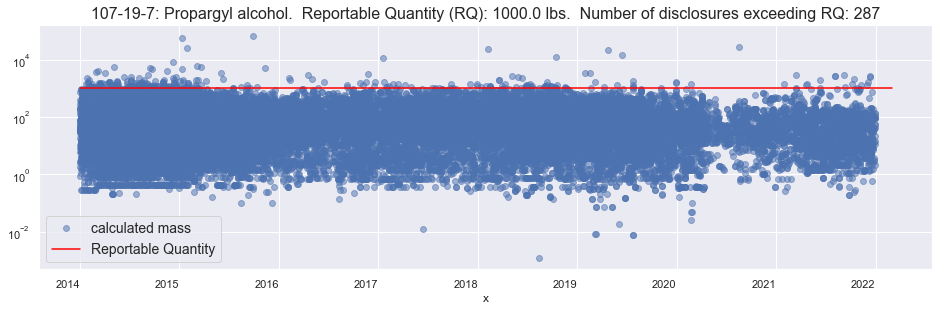

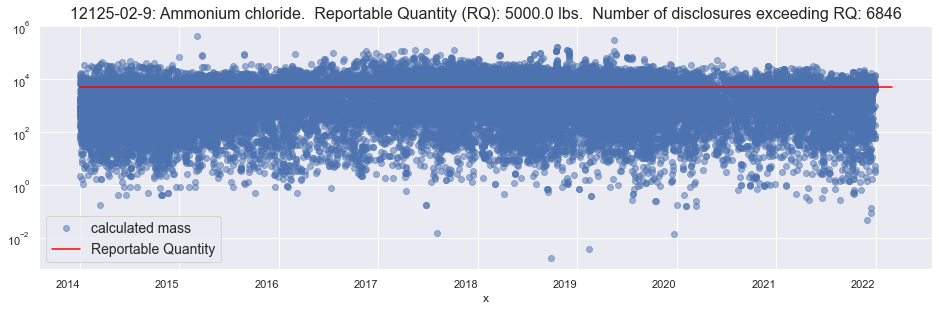

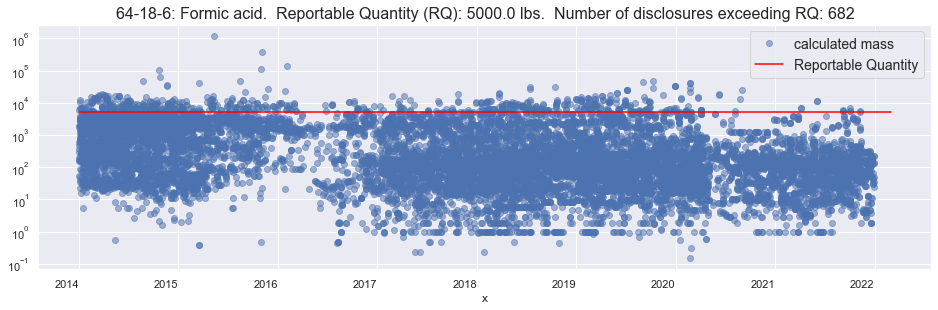

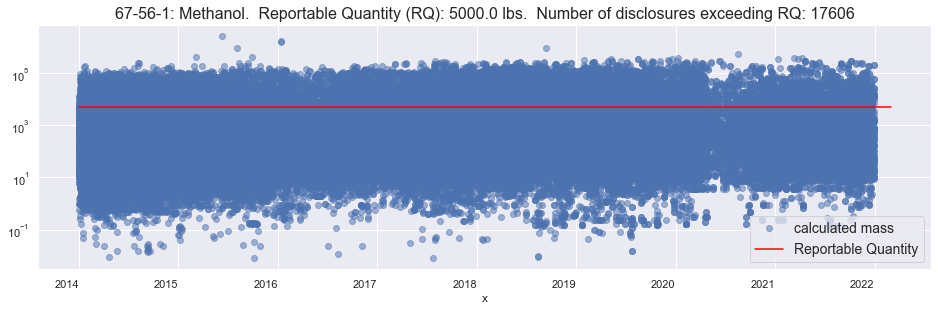

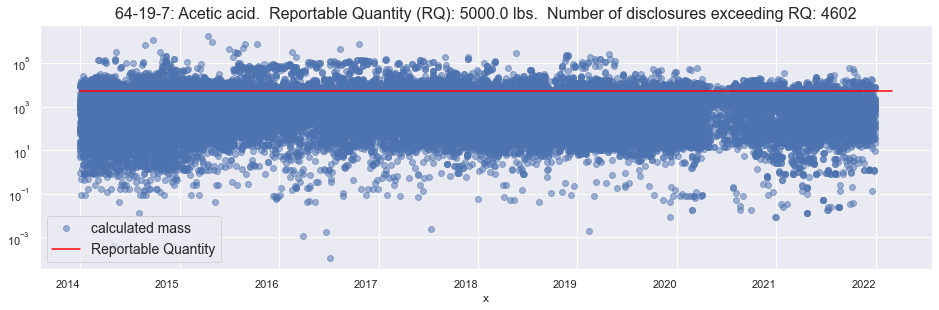

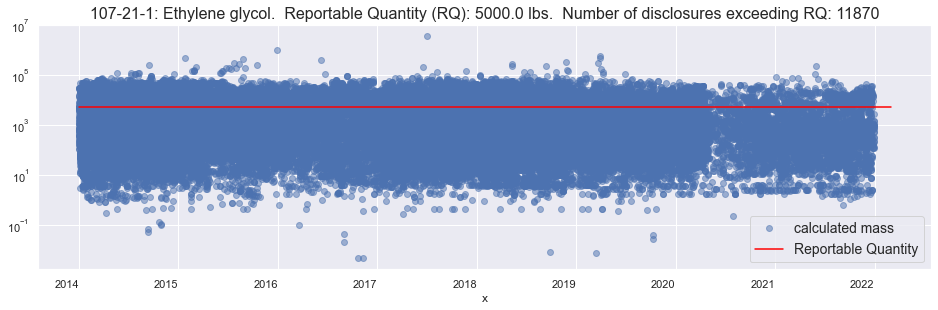

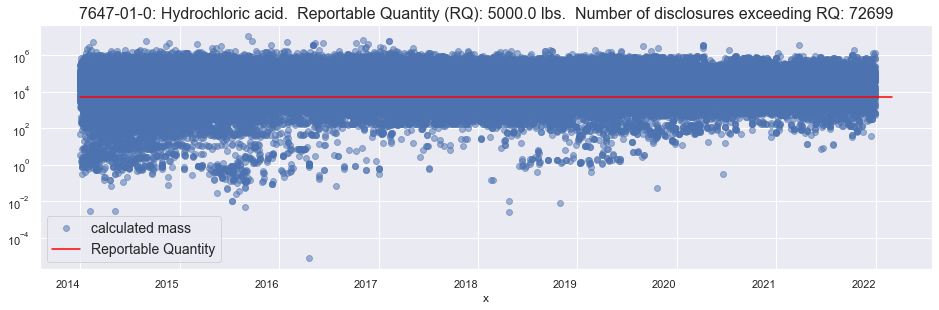

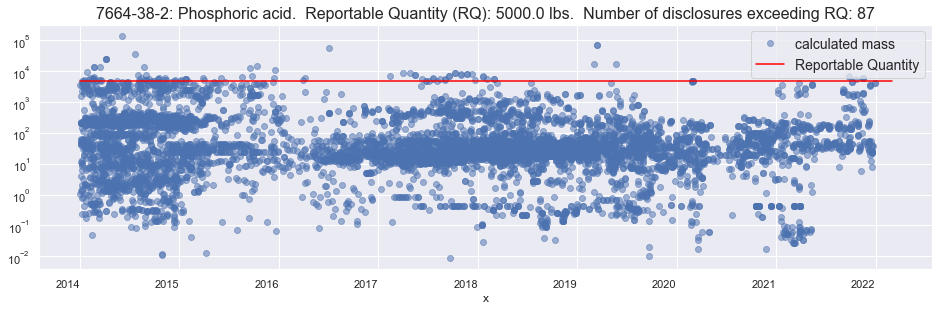

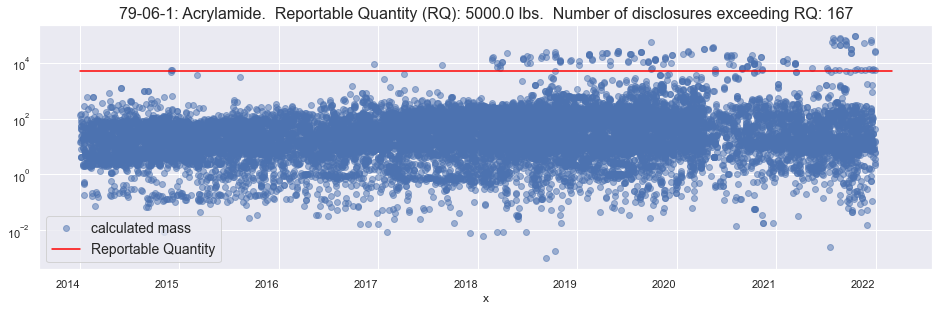

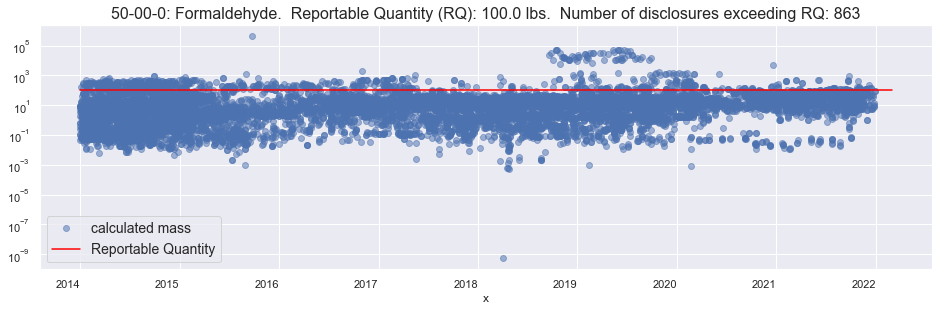

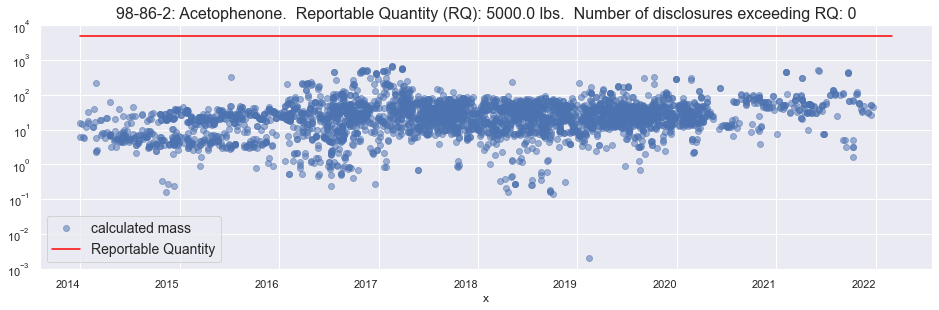

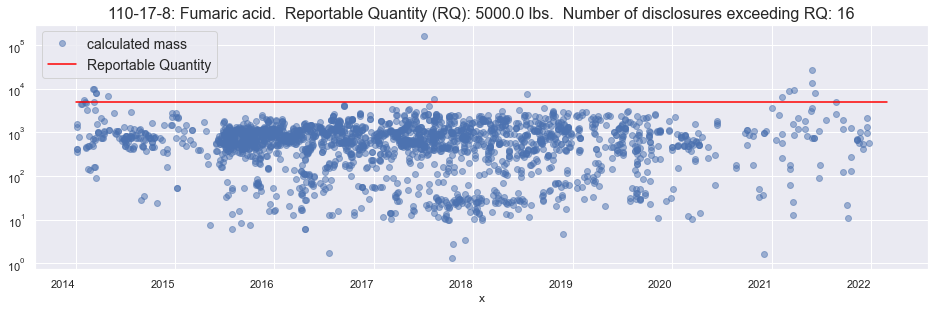

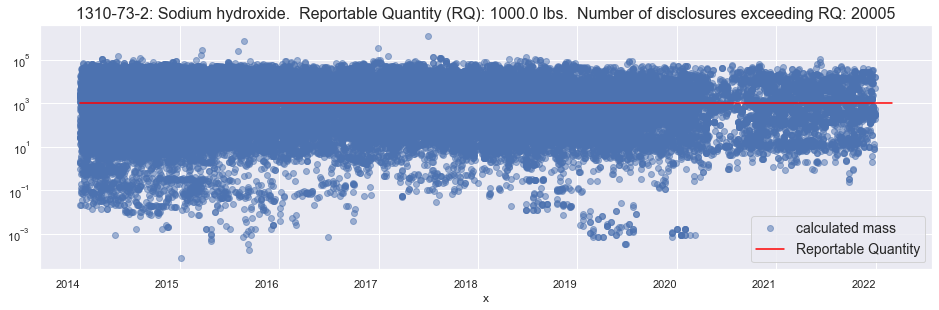

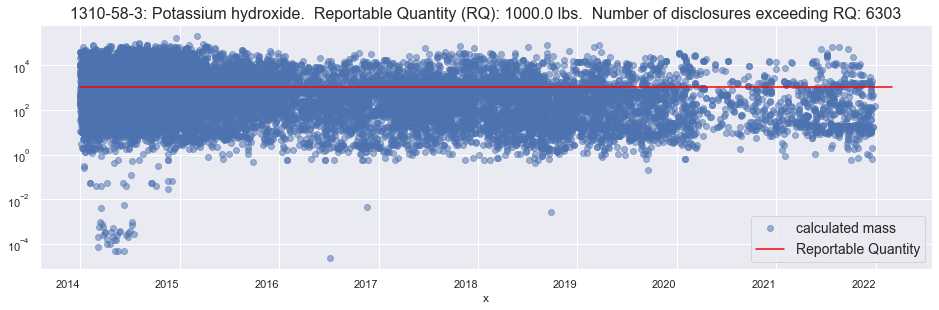

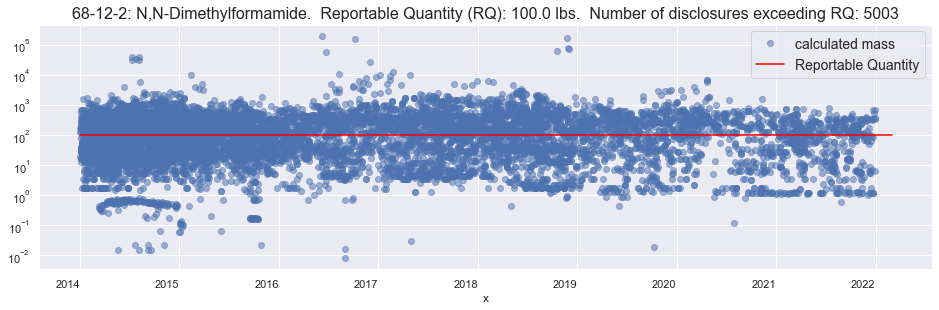

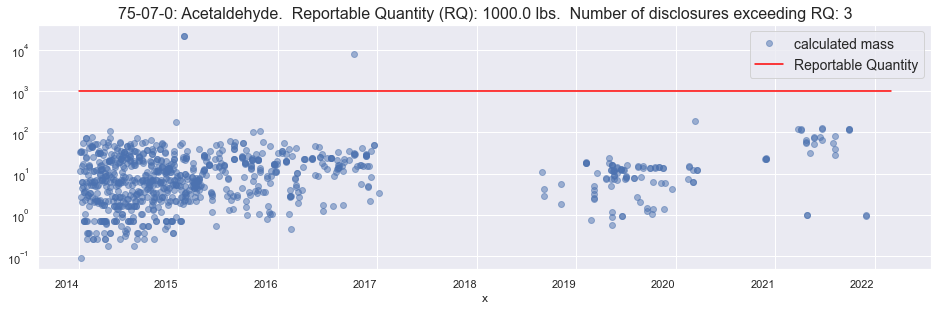

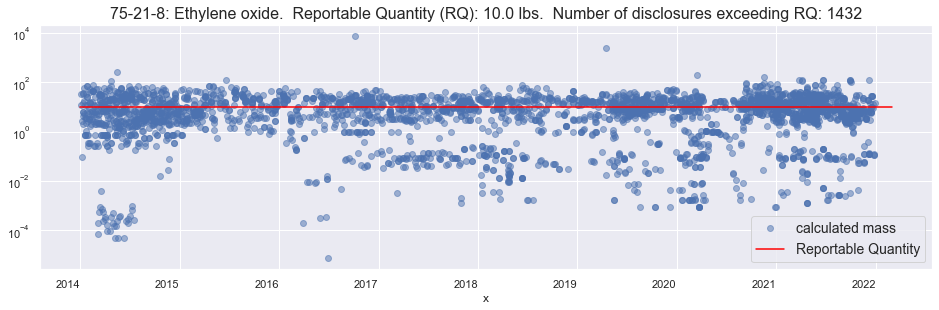

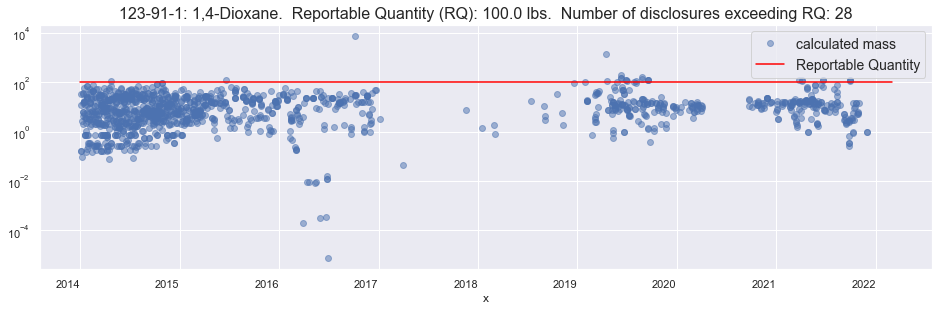

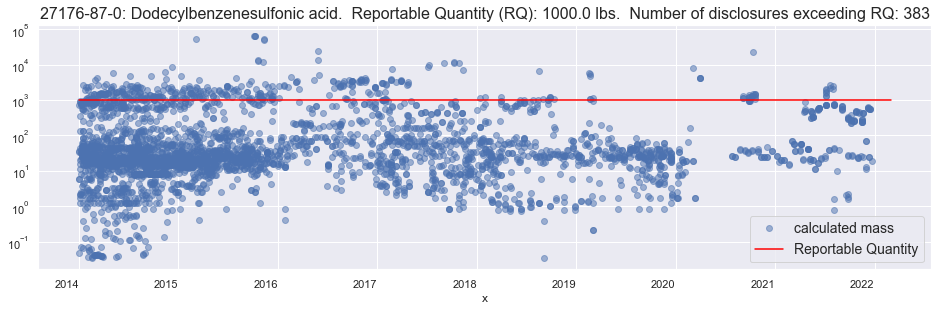

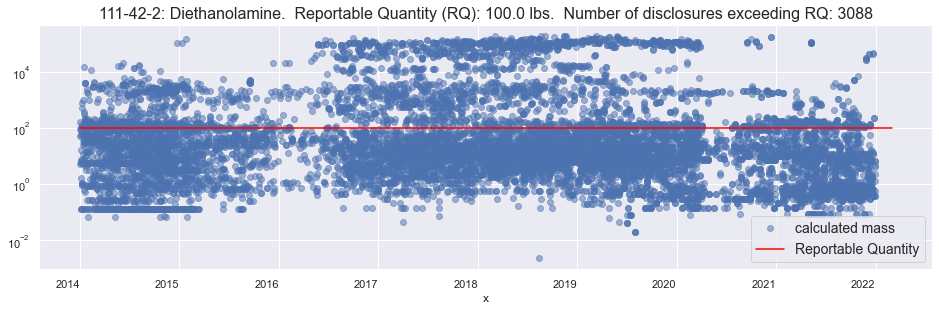

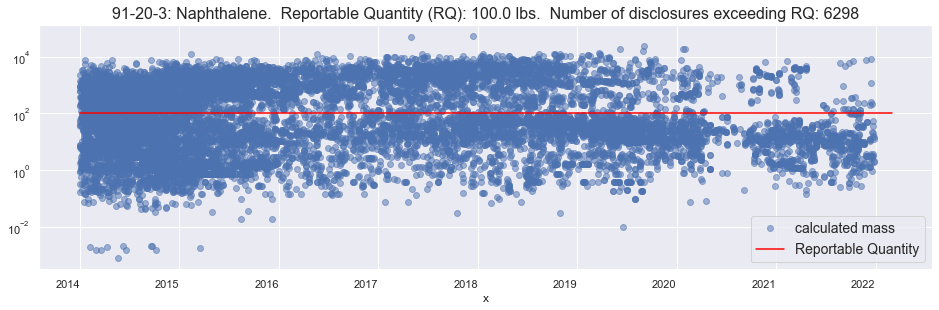

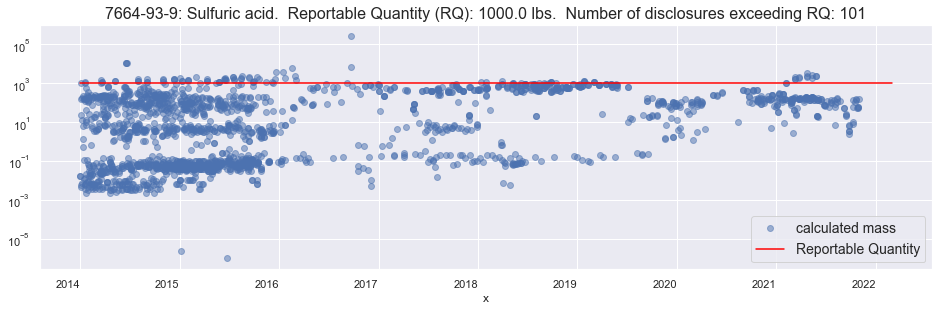

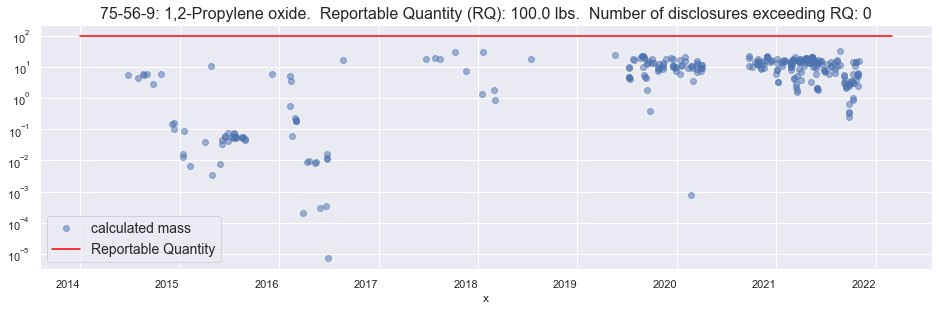

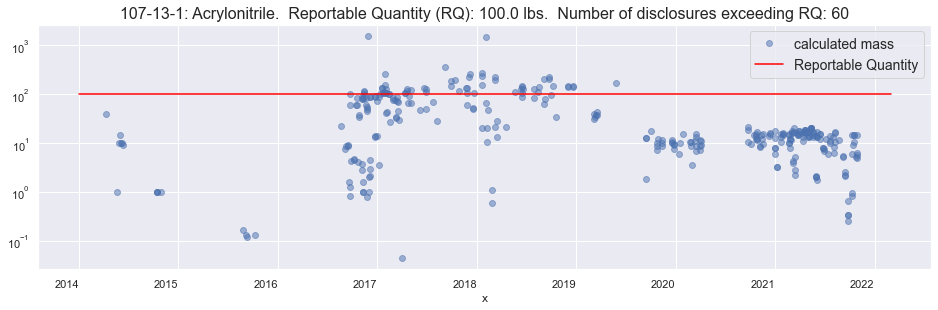

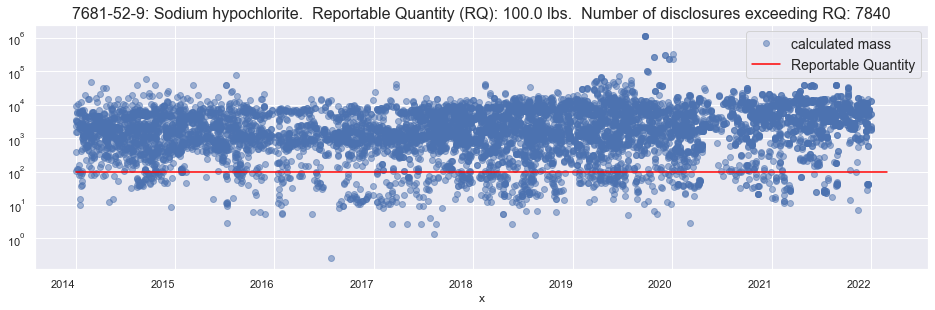

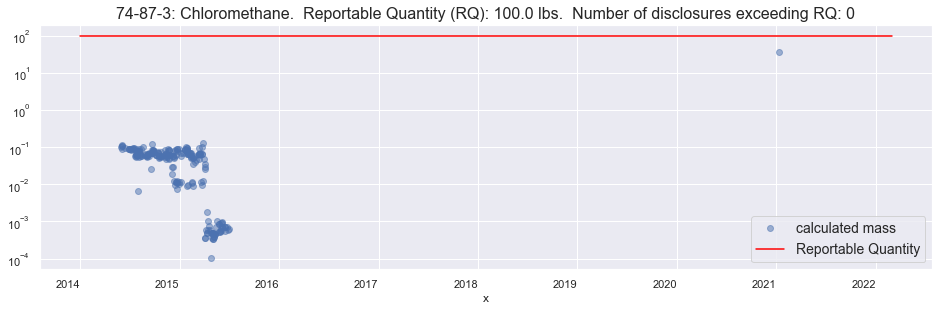

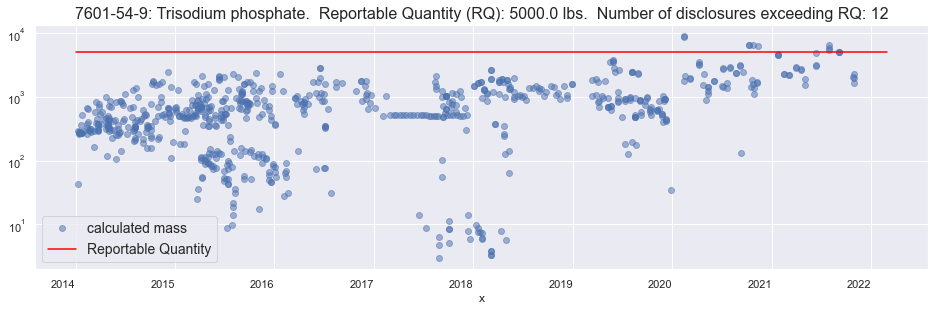

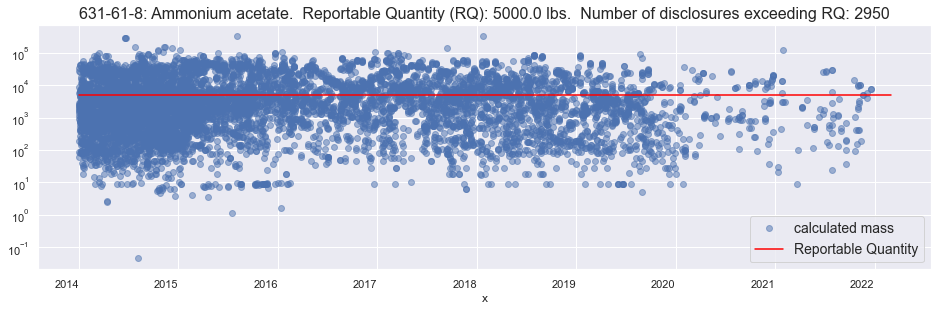

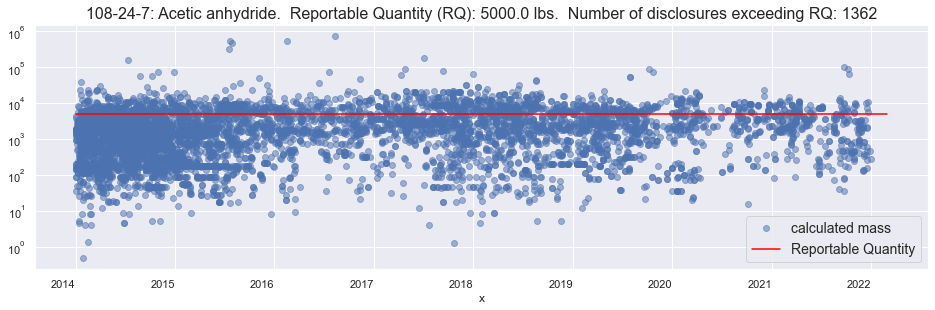

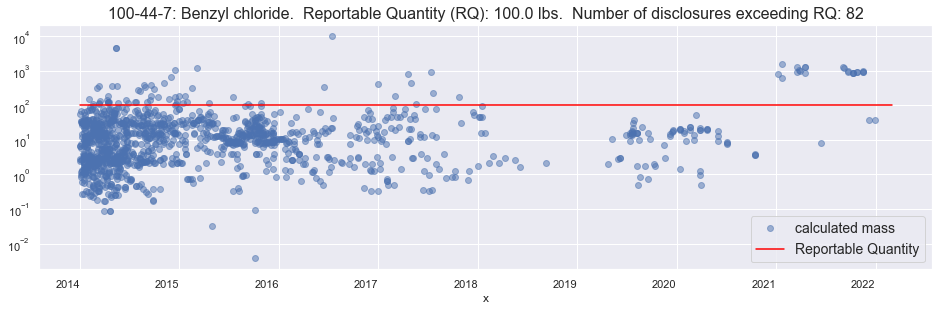

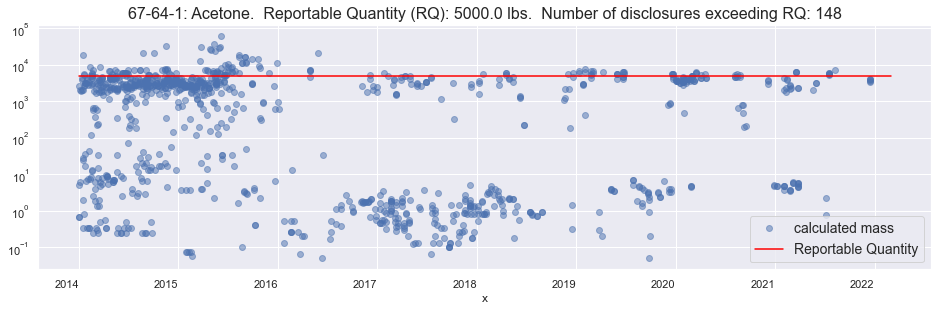

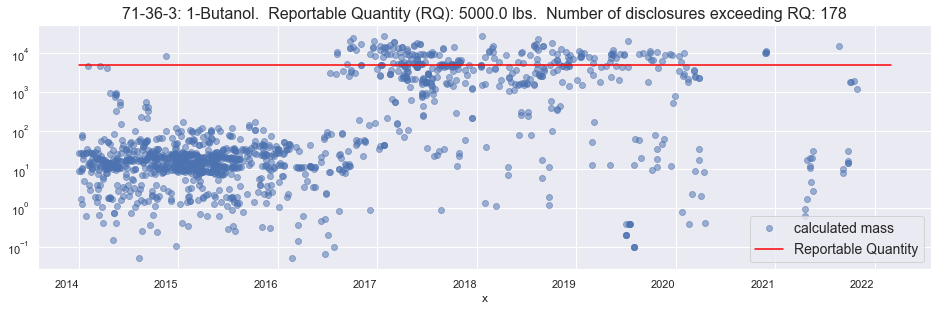

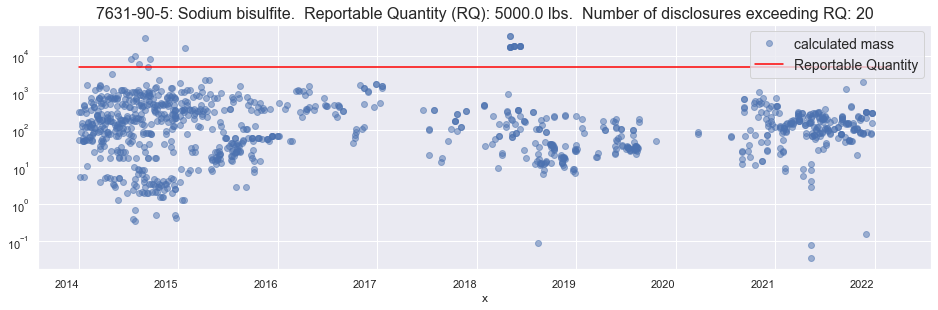

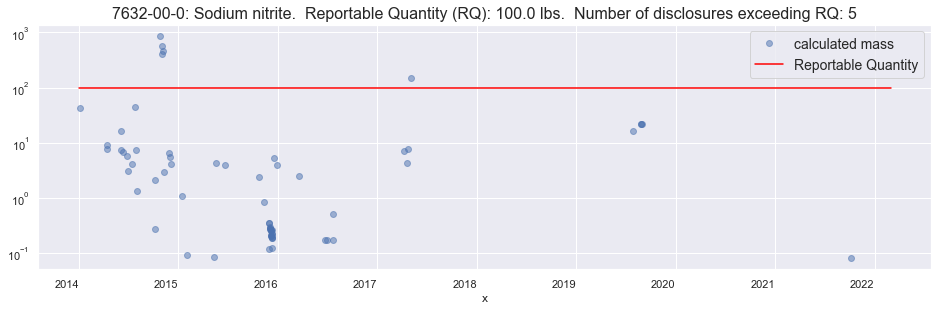

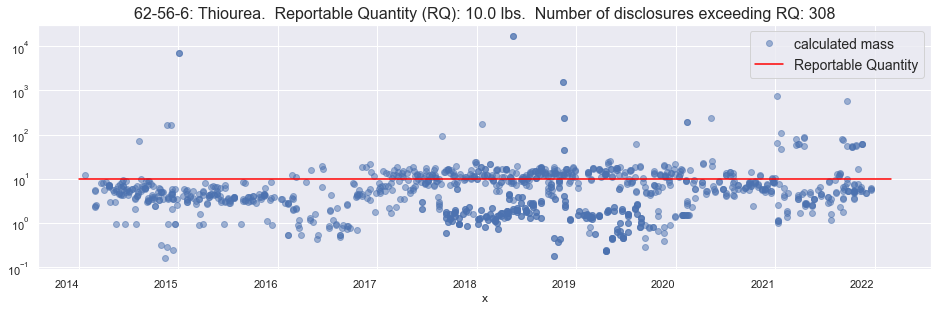

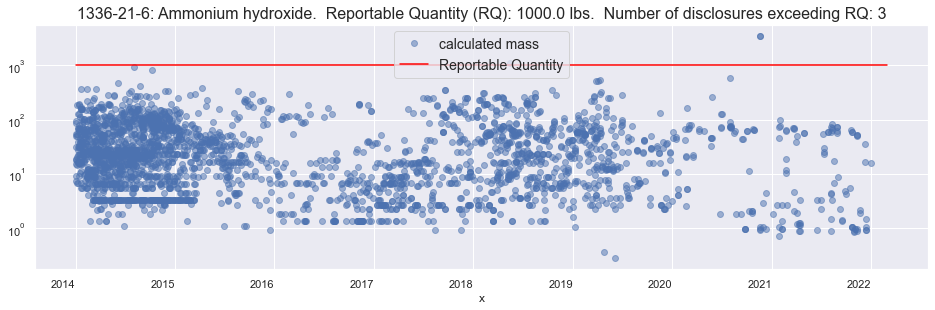

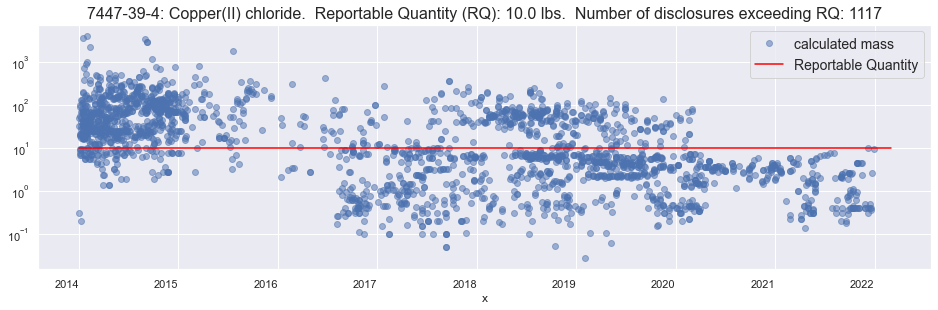

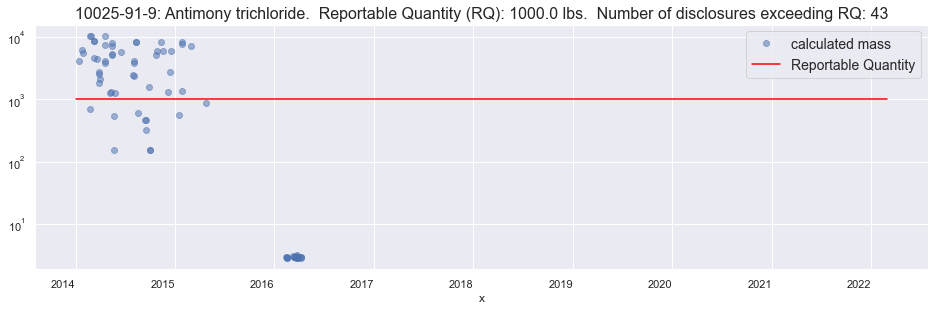

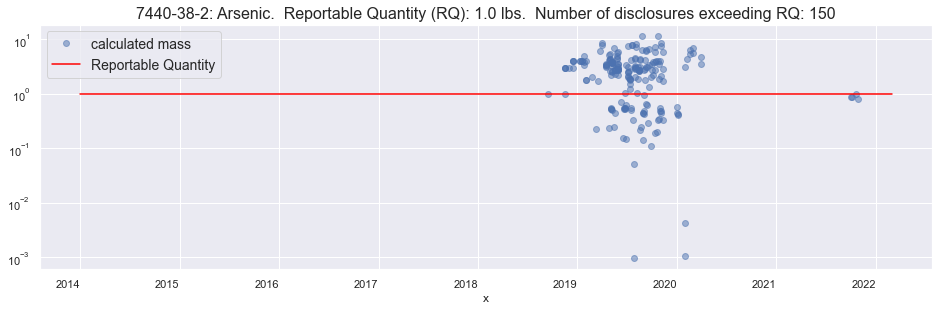

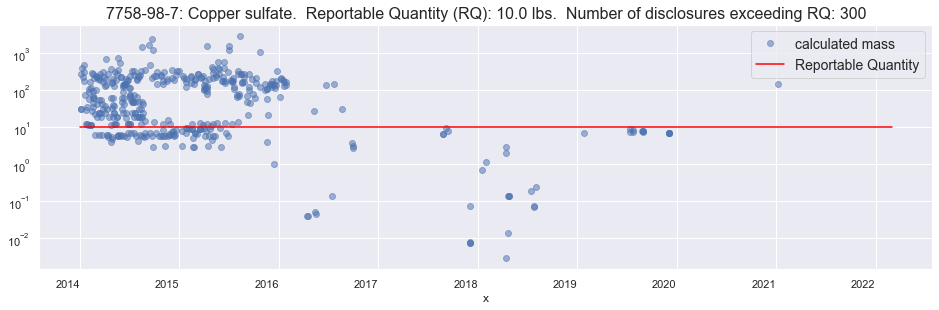

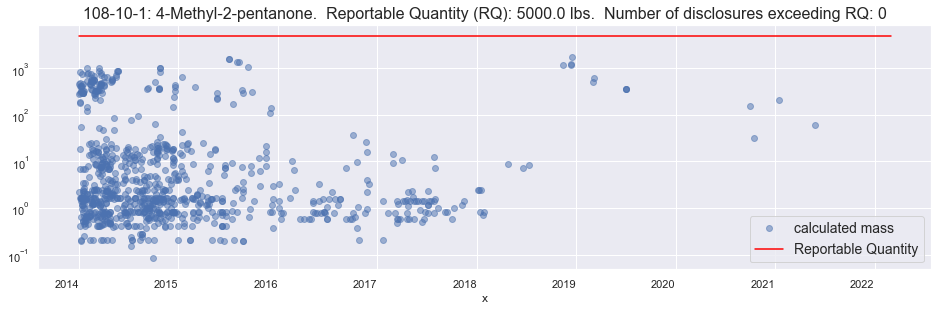

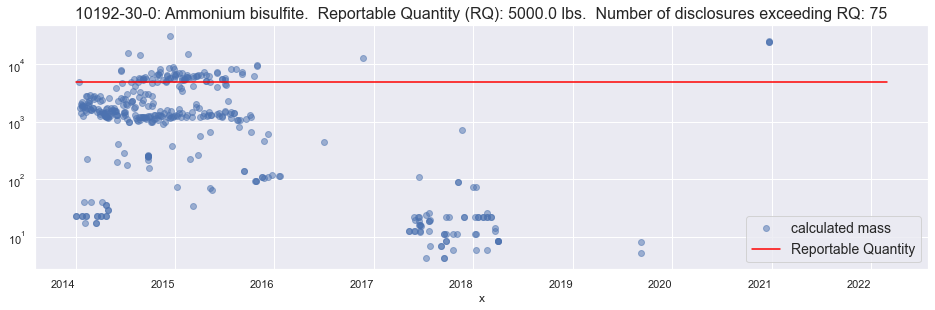

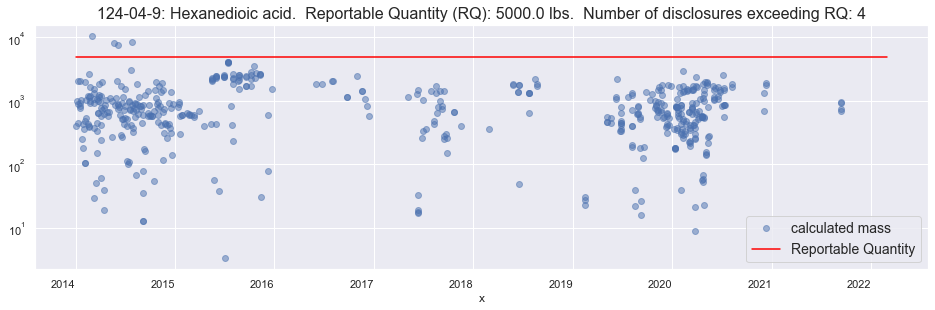

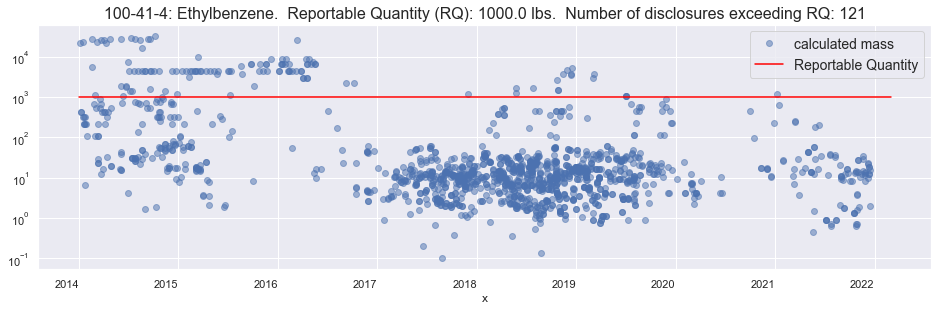

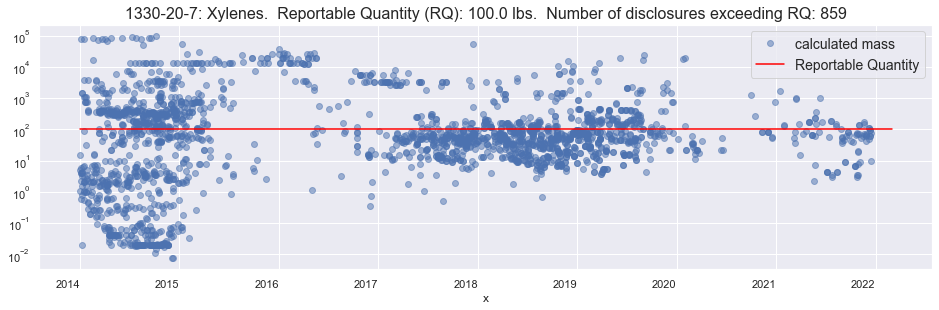

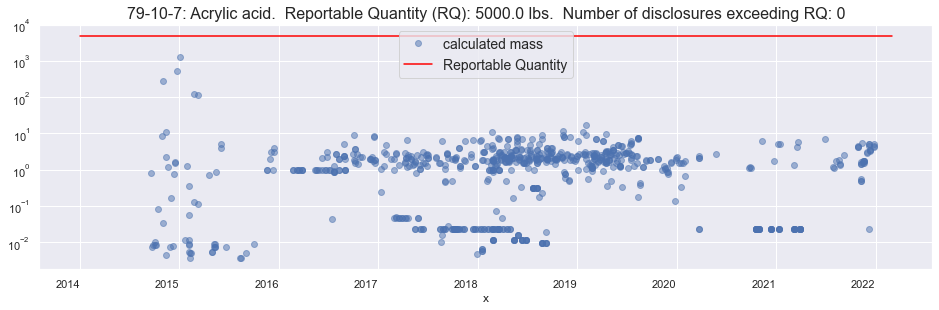

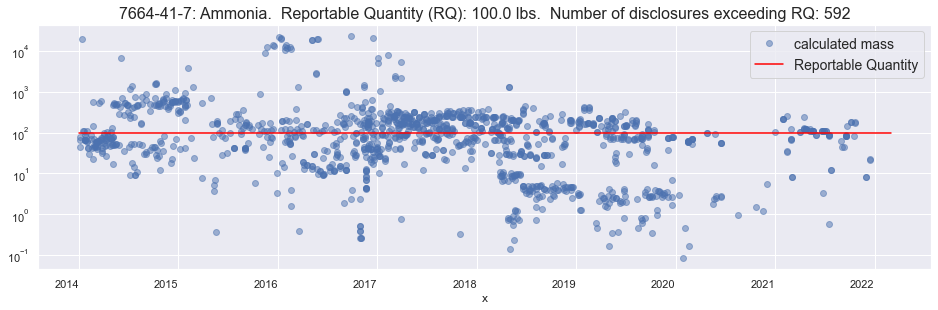

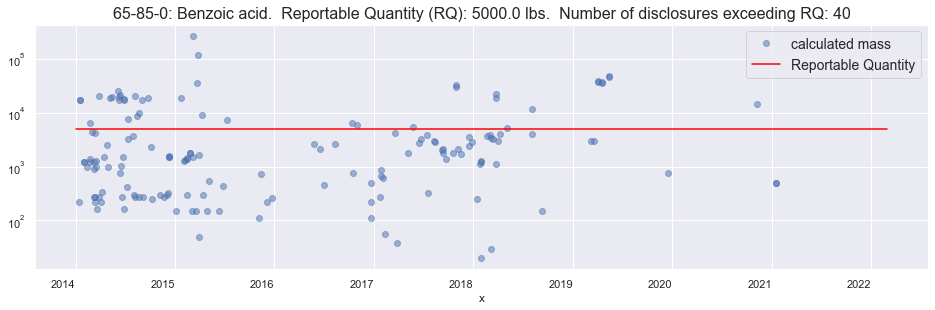

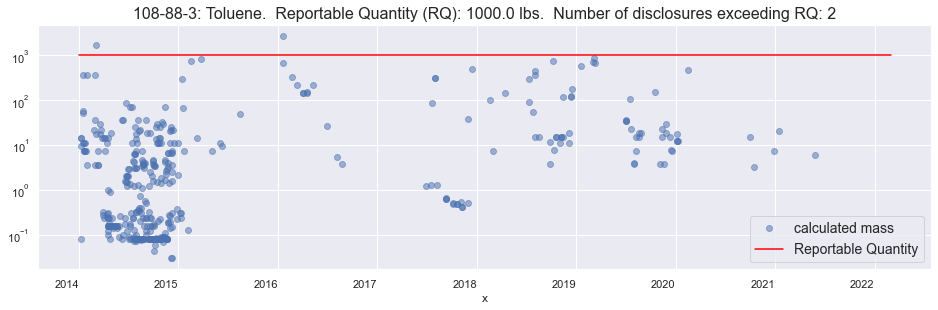

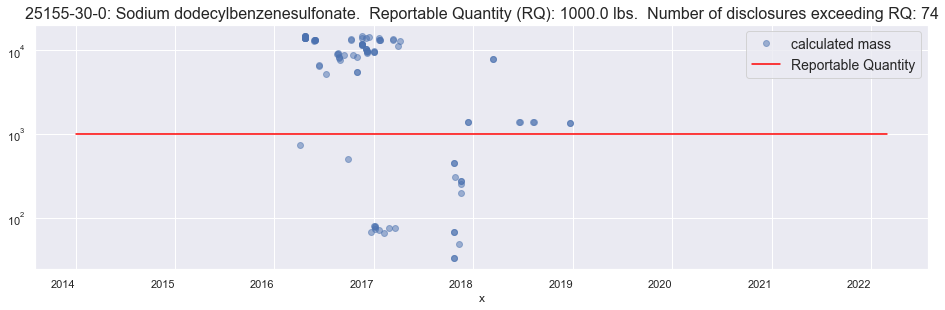

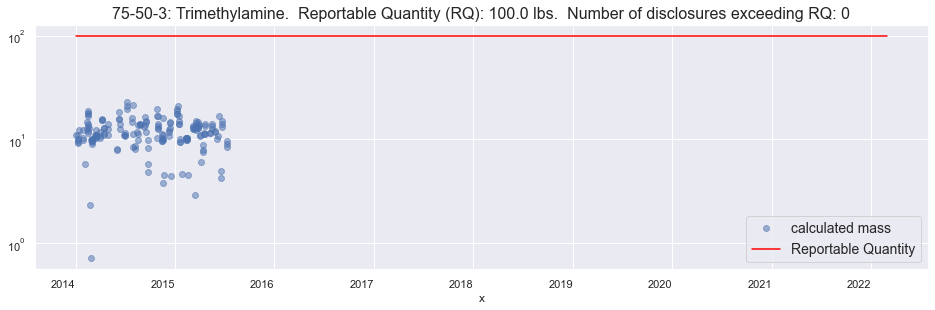

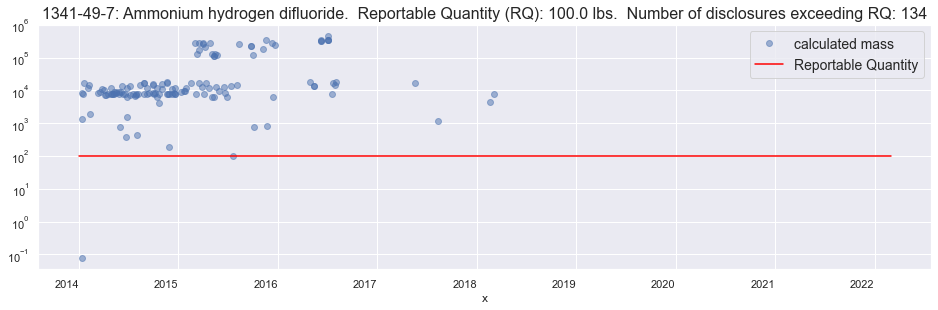

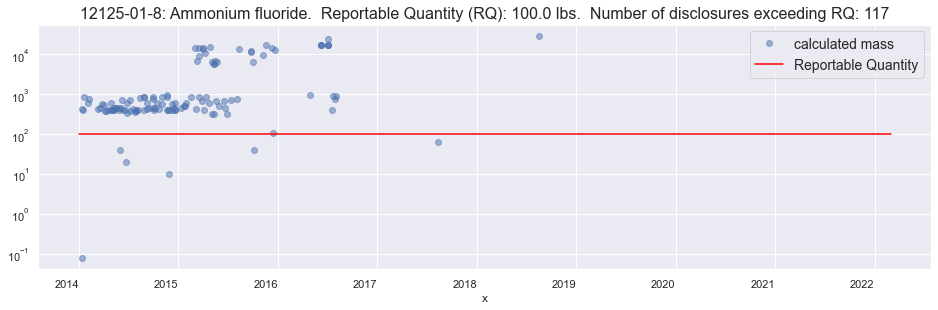

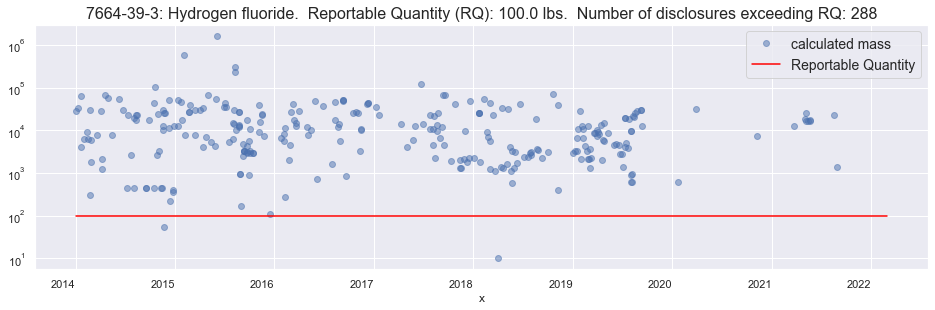

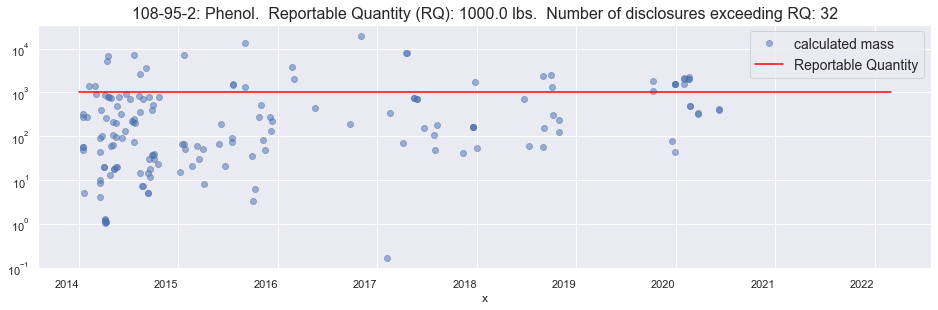

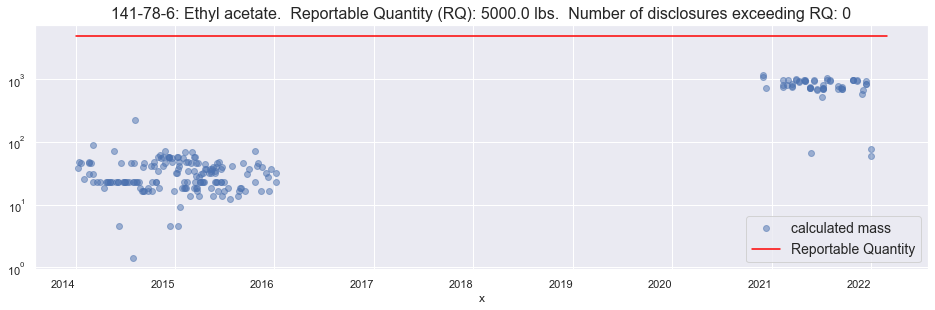

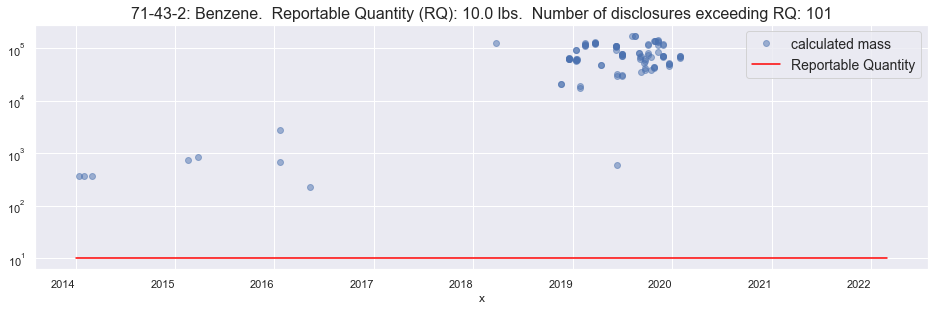

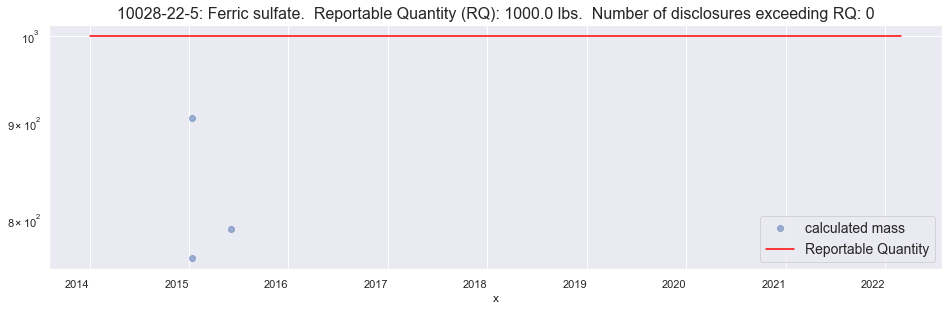

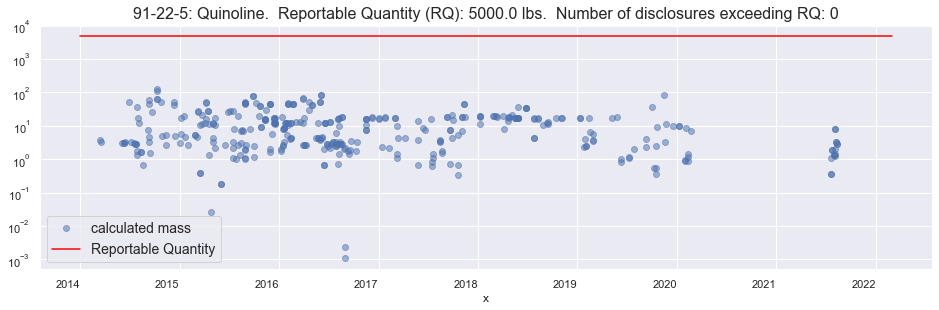

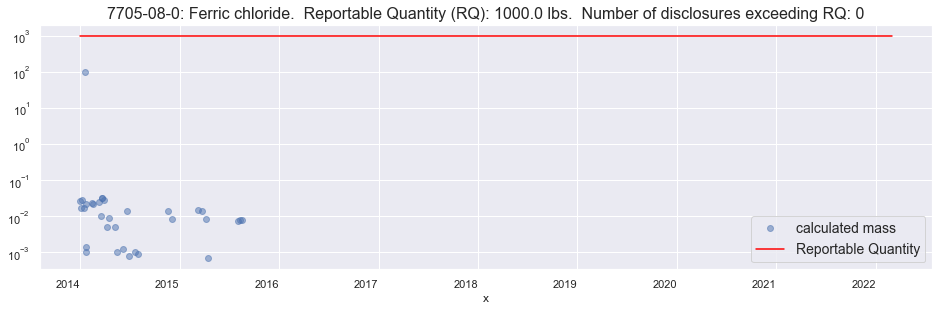

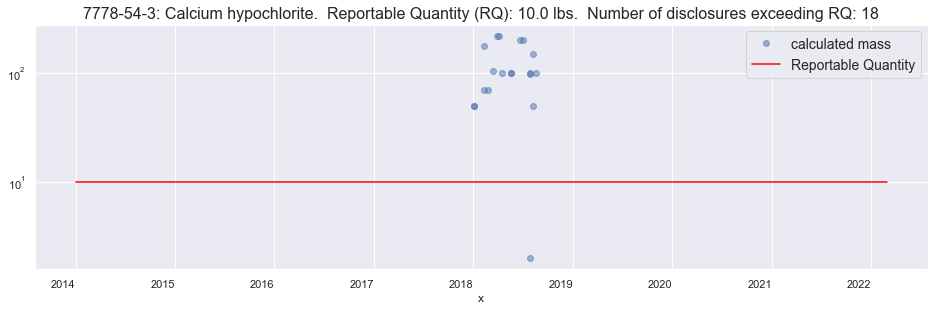

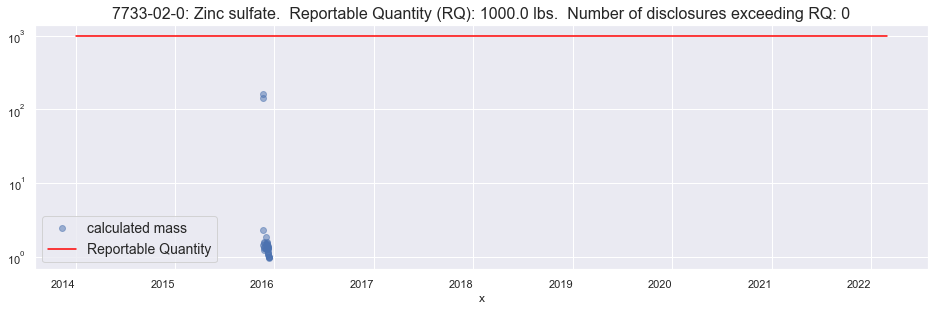

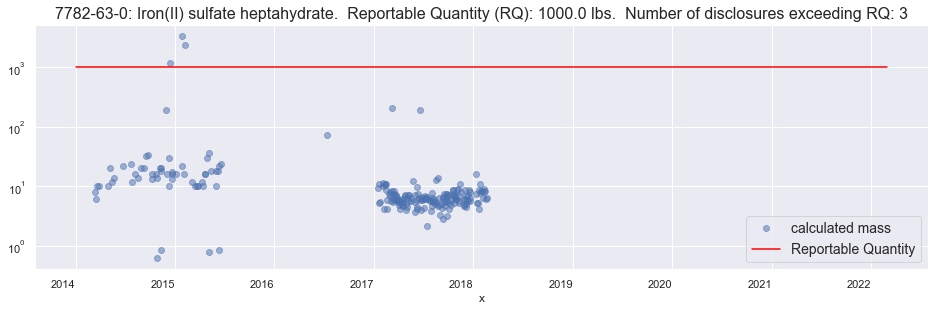

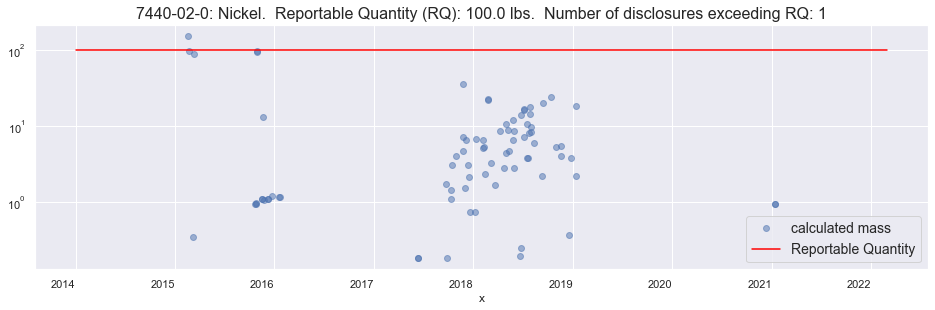

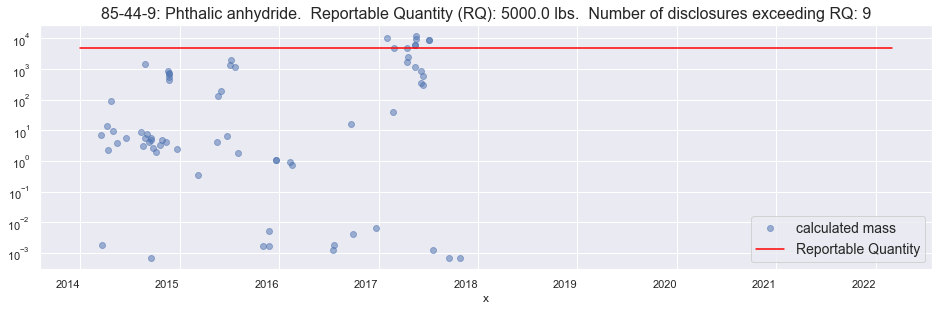

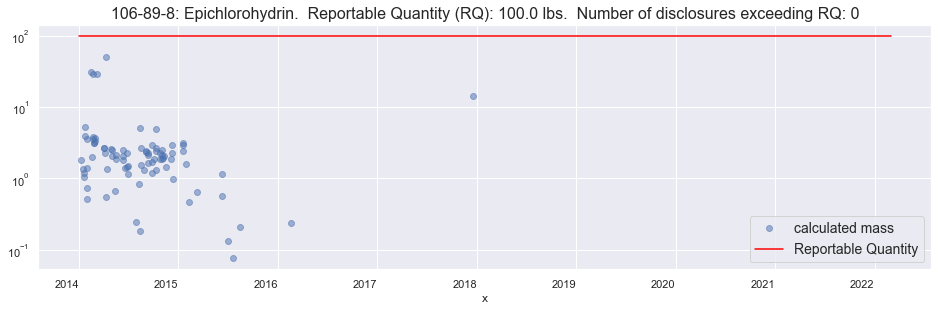

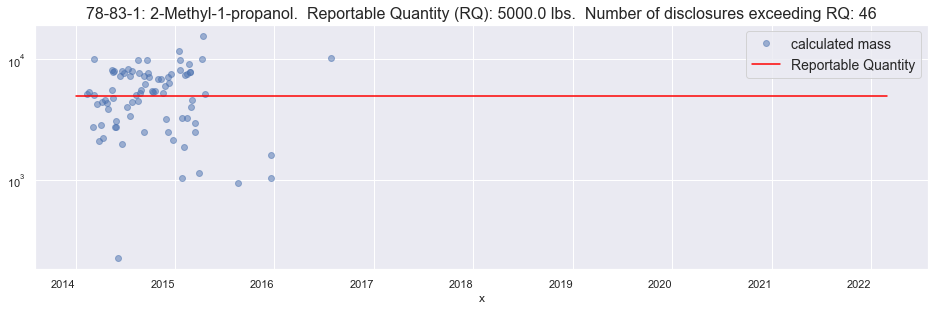

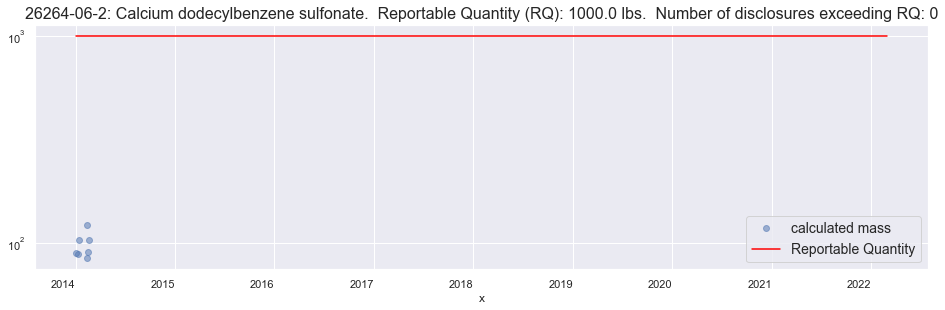

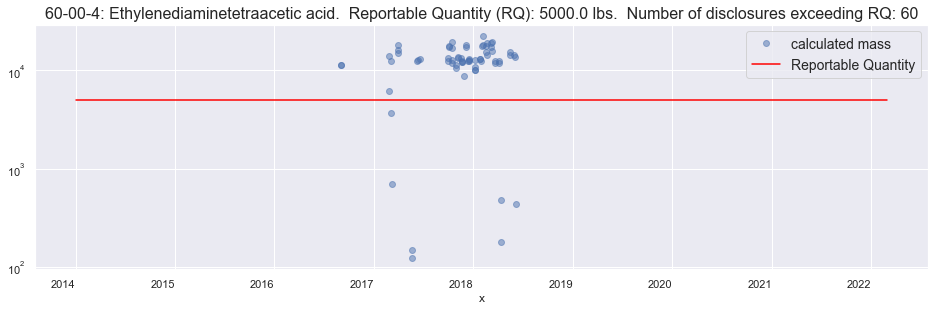

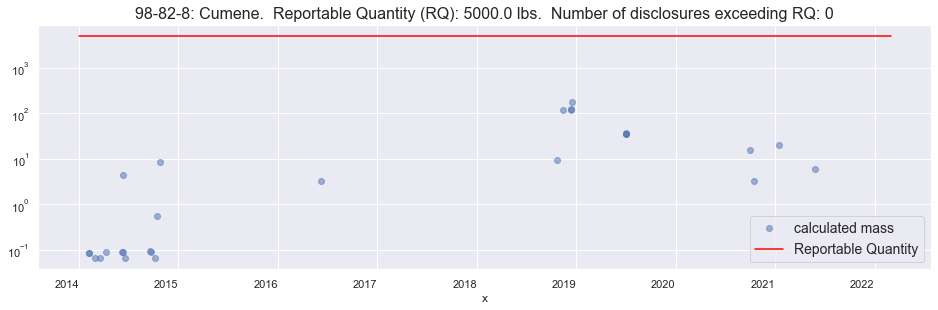

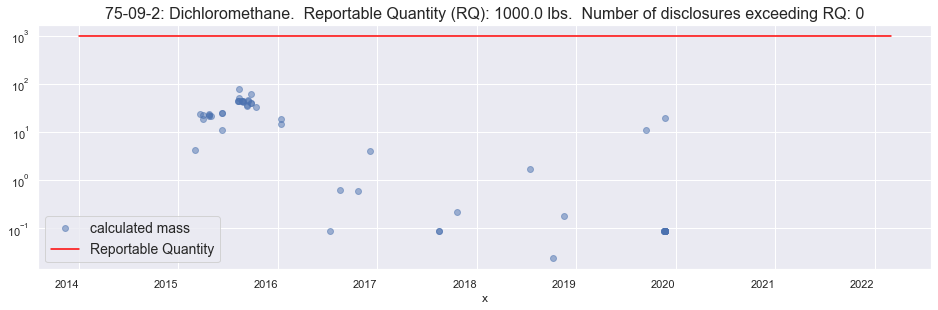

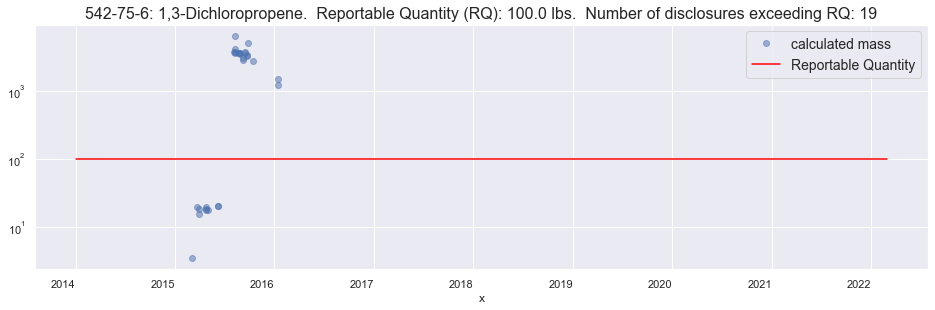

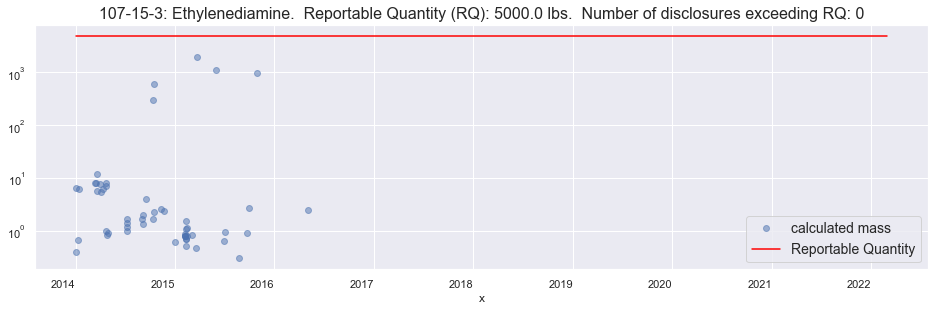

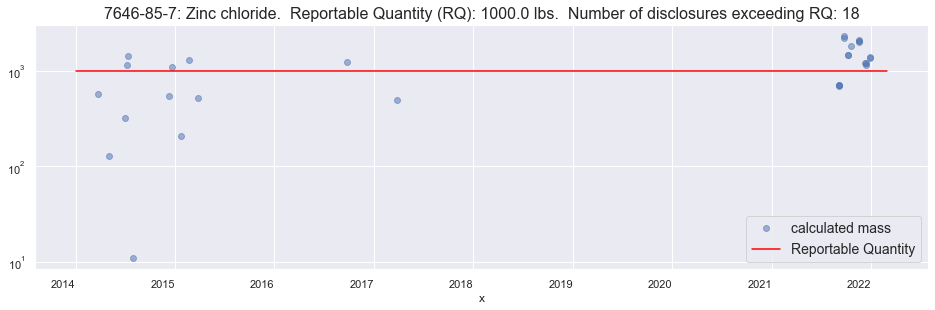

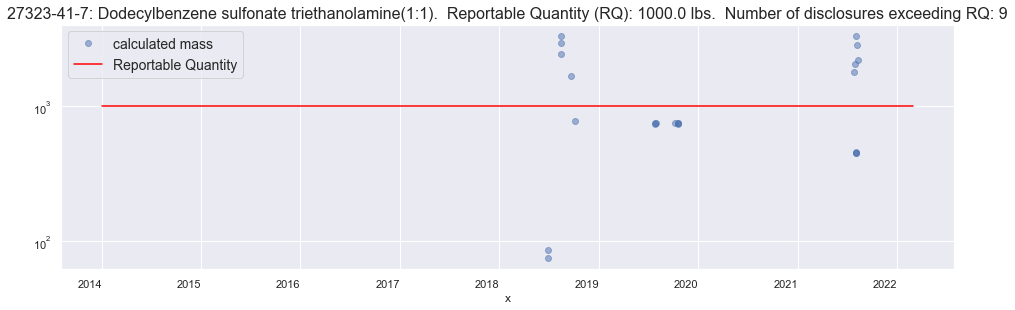

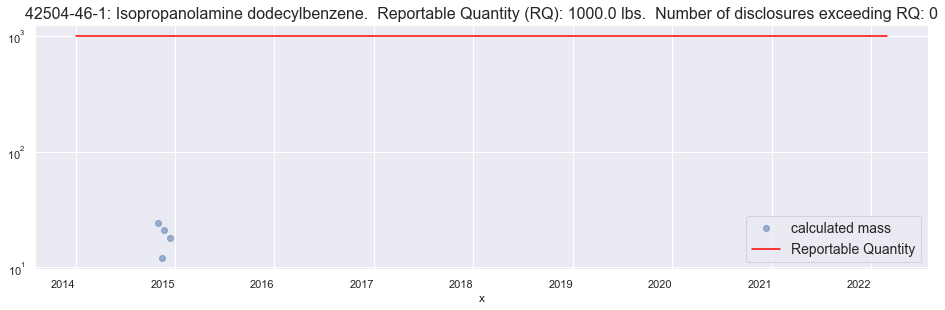

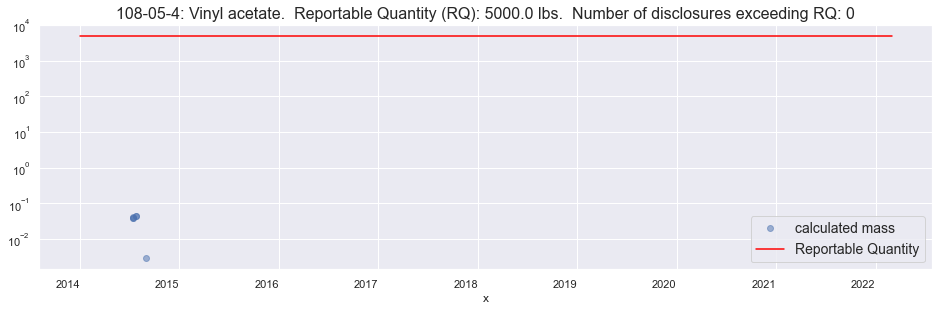

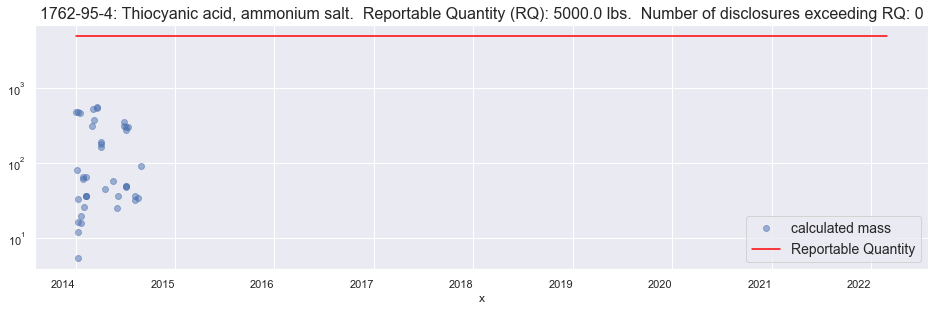

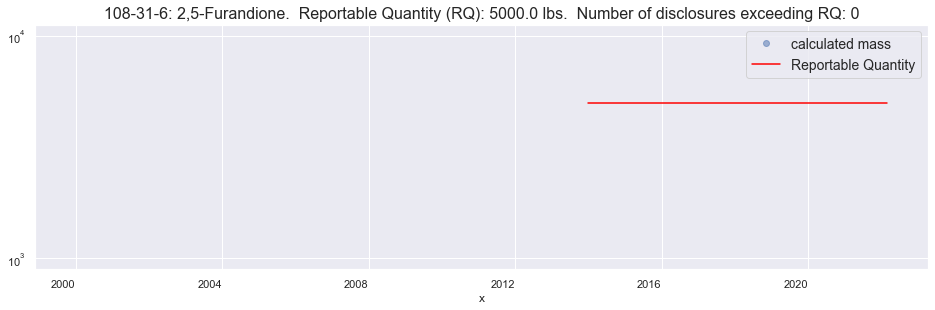

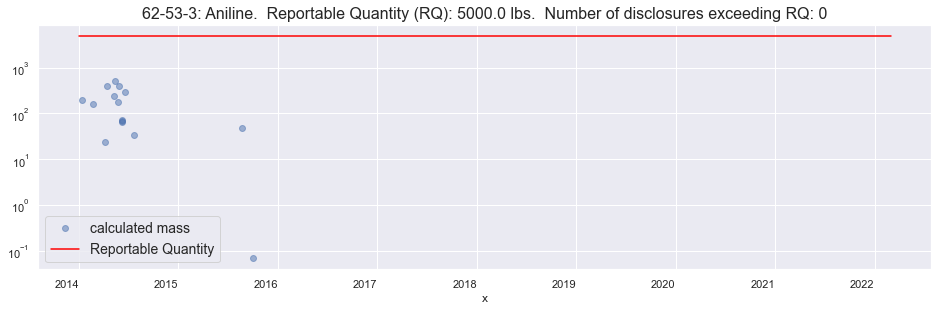

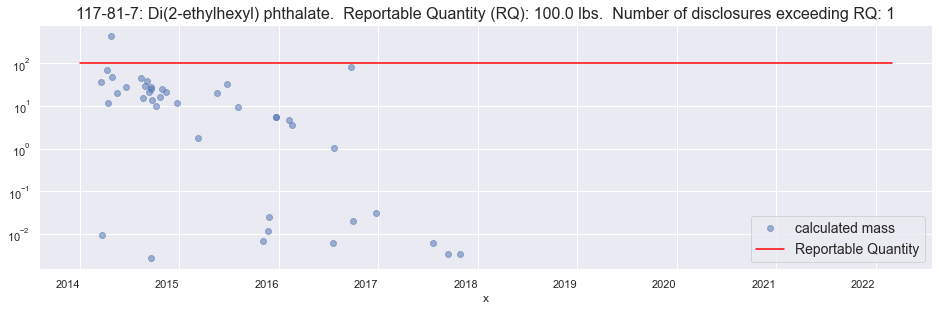

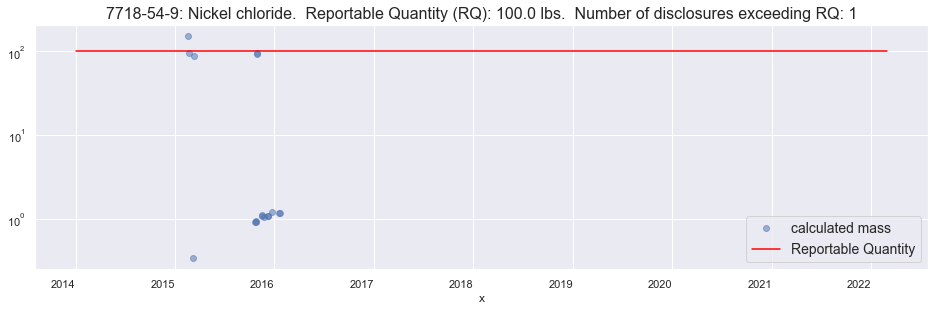

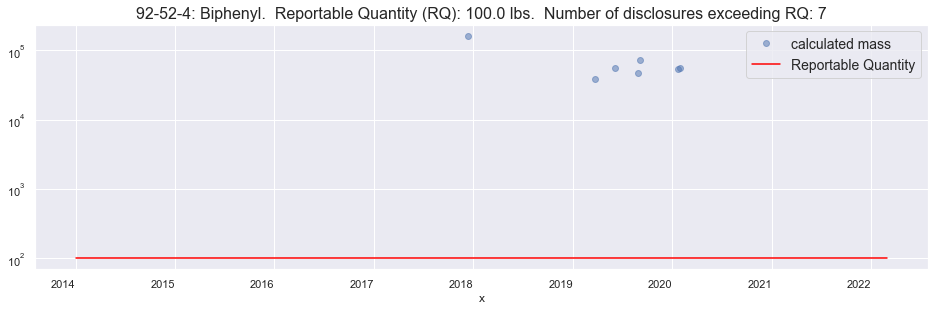

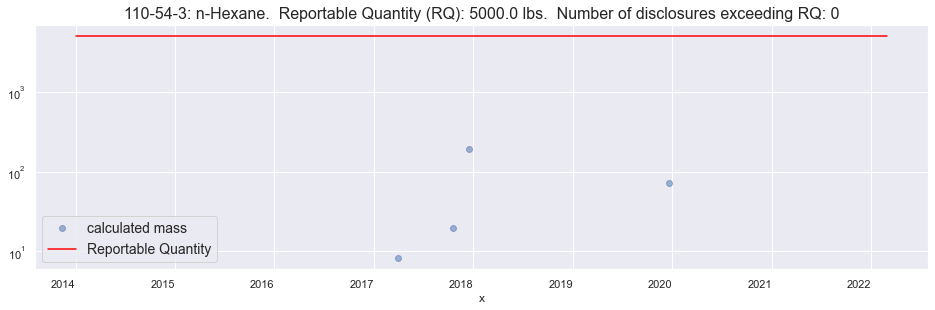

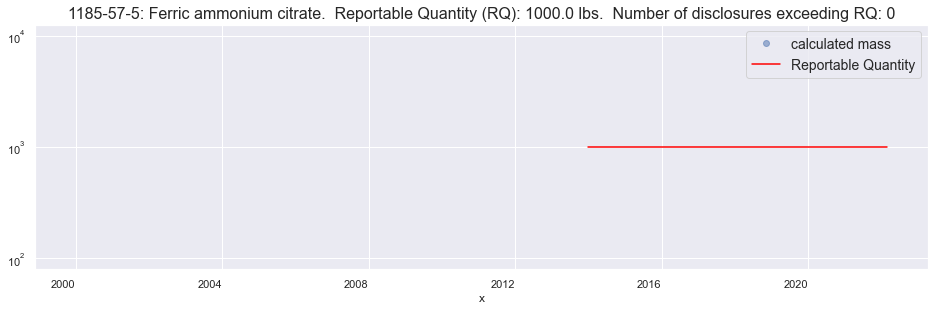

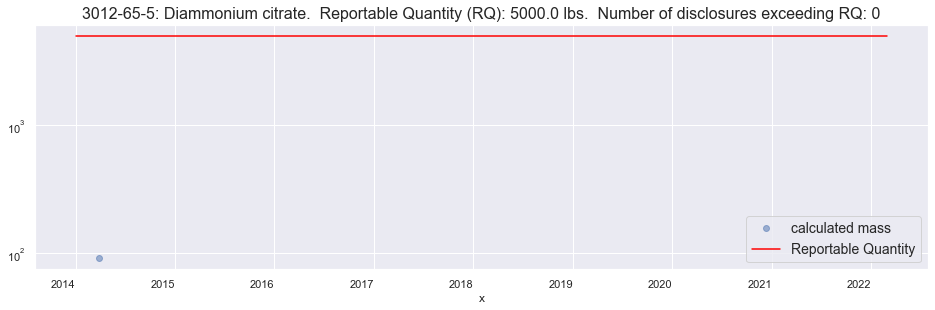

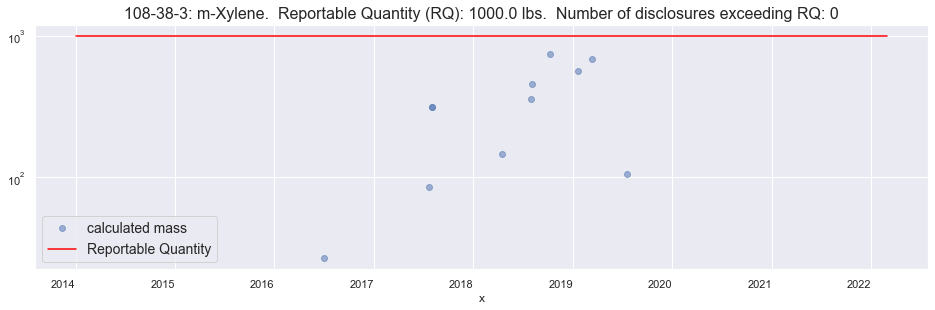

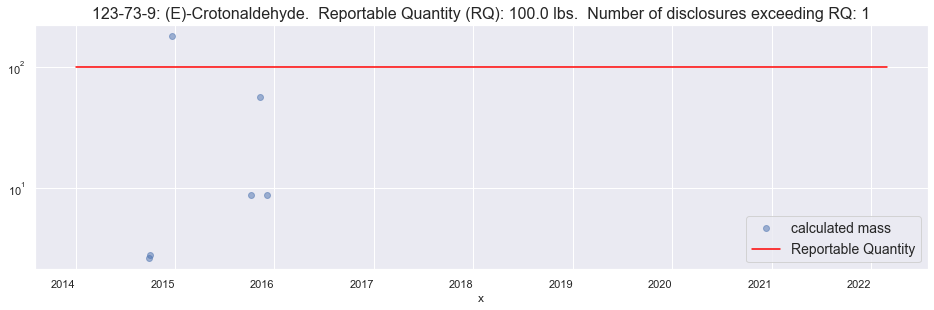

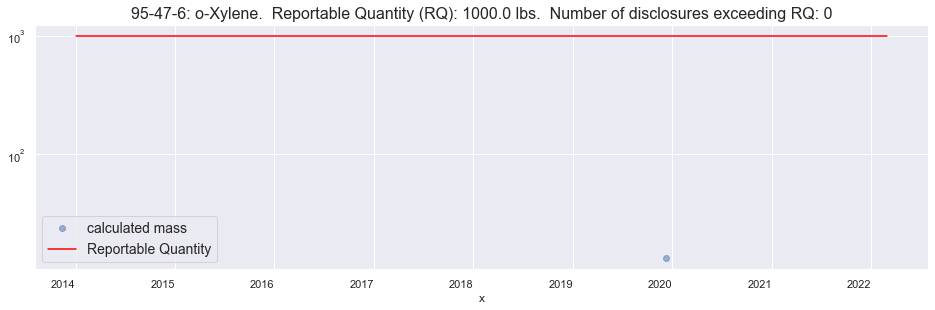

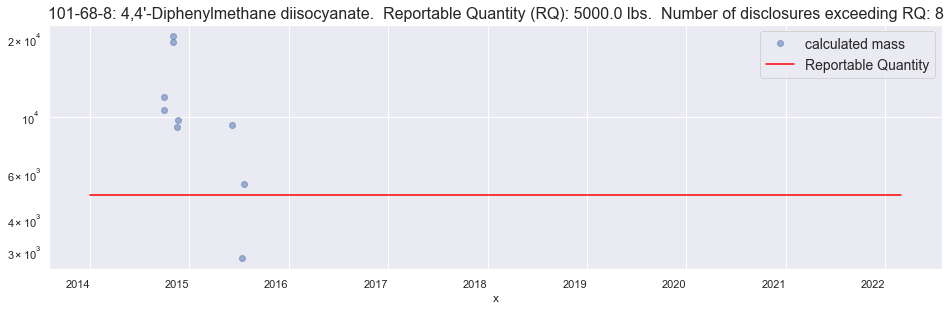

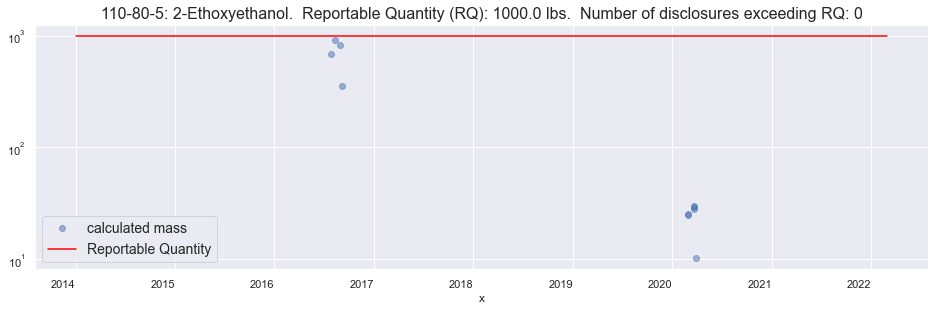

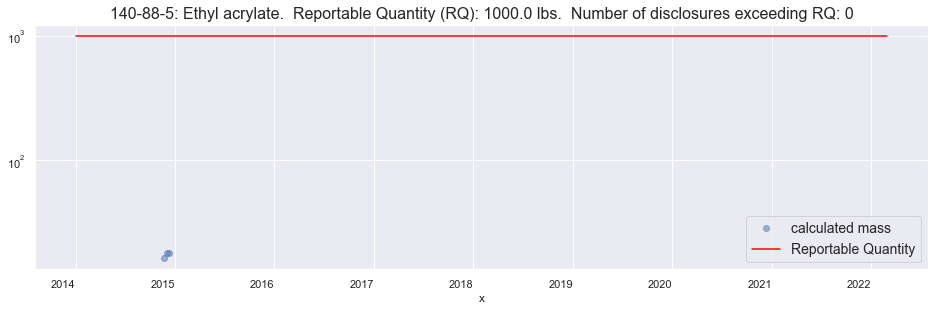

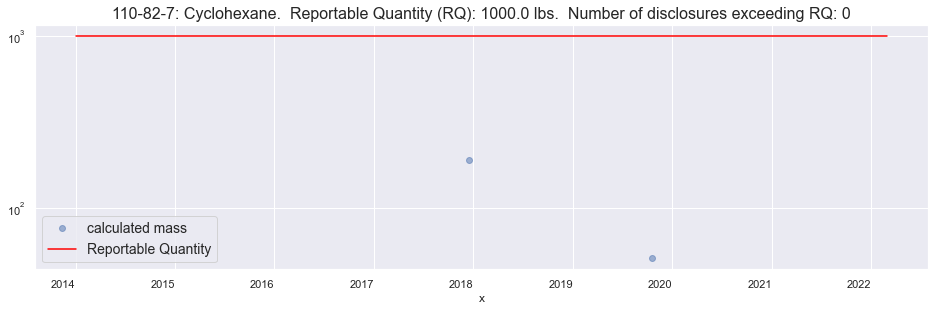

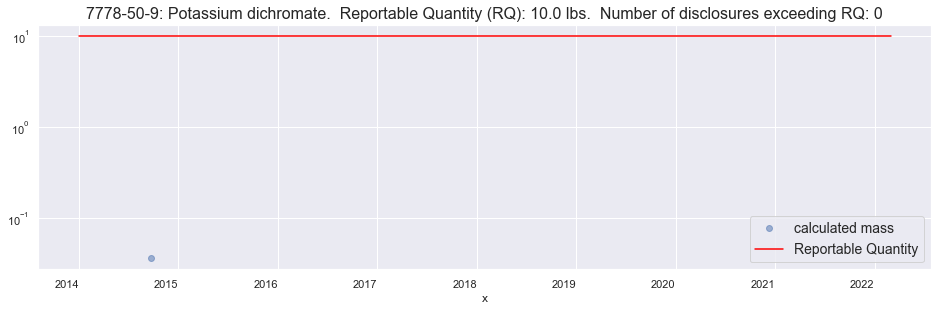

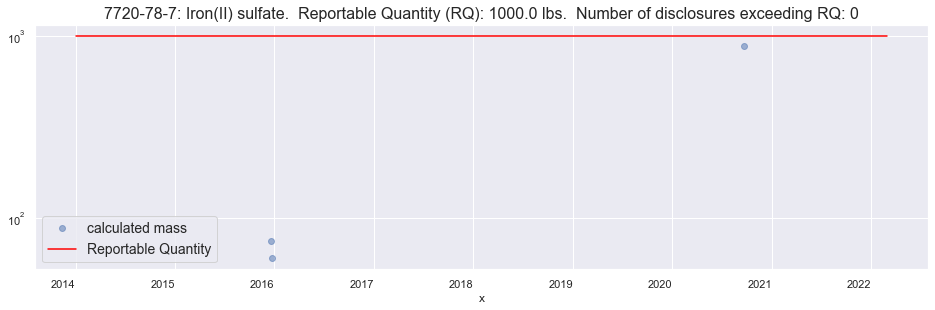

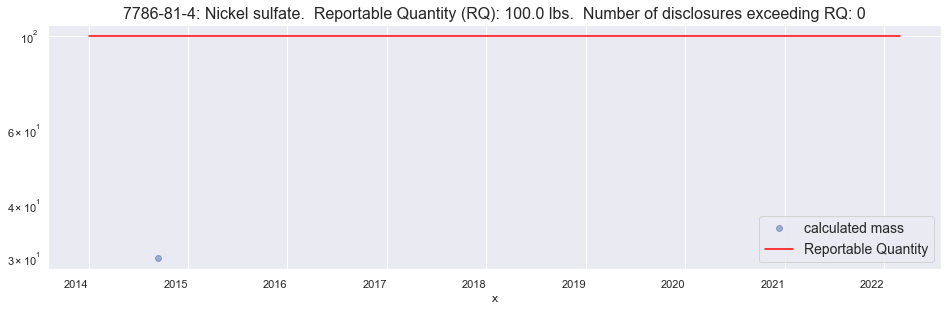

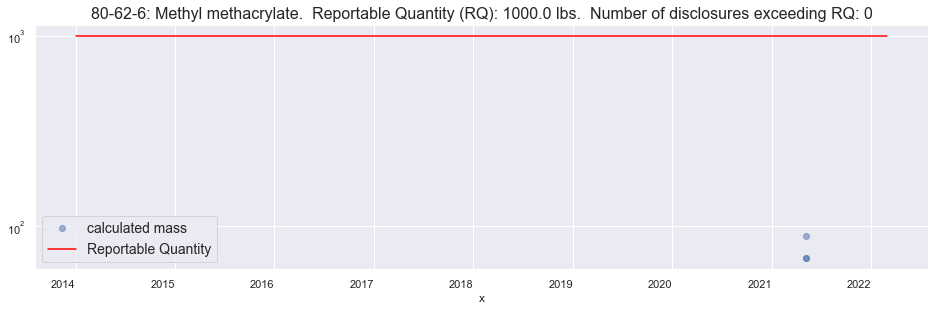

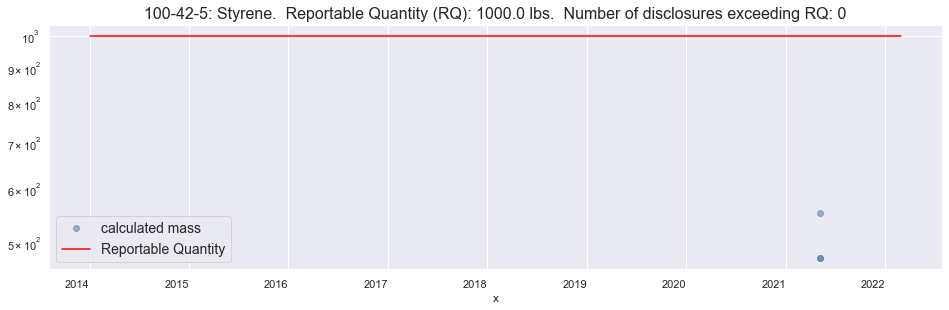

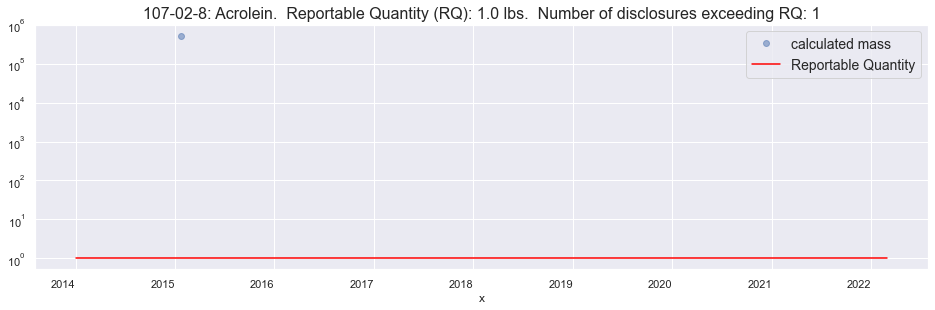

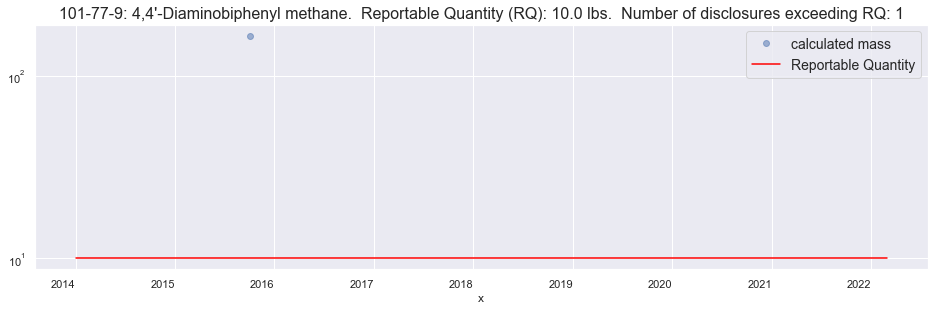

In [10]:
import datetime
out_figs = './fig_images/'
import seaborn as sns; sns.set_theme()

def plot_rq(df,cas):
    t = df[df.bgCAS==cas].reset_index(drop=True)
    rq = t.iloc[0].rq_lbs
    ename = t.iloc[0].epa_pref_name
    overrq = len(t[t.calcMass>t.rq_lbs])
    ax = t.plot('date','calcMass',logy=True,style='o',alpha=0.5,figsize=(16,5))
    ax.set_title(f'{cas}: {ename}.  Reportable Quantity (RQ): {rq} lbs.  Number of disclosures exceeding RQ: {overrq}',fontsize=16)
    start = datetime.date(2014,1,1)
    end = datetime.date(2022,3,1)
    ln = pd.DataFrame({'x':[start,end],'y':[rq,rq]})
    #print(ln)
    ln.plot('x','y',color='red',ax=ax)
    ax.legend(['calculated mass', 'Reportable Quantity'],
         fontsize=14);
#     print(t[t.calcMass>t.rq_lbs][['APINumber','date','bgCAS','calcMass','rq_lbs']].sort_values('date'))
    plt.savefig(out_figs+f'RQ_{cas}.png',pad_inches=1,bbox_inches = 'tight')
    plt.show()

c1 = t.is_on_DWSHA
print(f'Number of disclosures with "reportable" masses for SDWA only:  {len(t[c1&(t.calcMass>t.rq_lbs)].UploadKey.unique())} of {len(sdf.UploadKey.unique())}')
print(f'Number of disclosures with "reportable" masses for whole list: {len(t[(t.calcMass>t.rq_lbs)].UploadKey.unique())} of {len(sdf.UploadKey.unique())}')

#lst = t[(t.is_on_DWSHA)].bgCAS.unique().tolist()
lst = t.bgCAS.unique().tolist()

# print(lst)
for cas in lst:
    if not cas in ['7440-36-0']: # don't do antimony
        plot_rq(t,cas)